# Credit Risk Default Prediction Model

Predicting `SeriousDlqin2yrs` - Binary indicator for serious delinquency within 2 years.

**Approach:** Inspired by Kaggle winning solutions with advanced preprocessing and model comparison.

---
## Section 1: Setup & Data Loading

In [1]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import make_column_transformer
from sklearn.pipeline import Pipeline

# Models
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
import lightgbm as lgb

# Metrics
from sklearn.metrics import (
    roc_auc_score, average_precision_score, roc_curve, precision_recall_curve,
    confusion_matrix, classification_report,
    precision_score, recall_score, f1_score
)

import joblib
import os

plt.style.use('fivethirtyeight')
print('Libraries imported!')

Libraries imported!


In [2]:
# Load data
DATA_PATH = '/Users/tomweinberg/credit-risk-modeling/data/raw/cs-training.csv'
MODEL_DIR = '/Users/tomweinberg/credit-risk-modeling/models'
os.makedirs(MODEL_DIR, exist_ok=True)

df = pd.read_csv(DATA_PATH, index_col=0)
target_col = 'SeriousDlqin2yrs'

print('='*60)
print('DATA SUMMARY')
print('='*60)
print(f'Dataset size: {df.shape[0]:,} rows x {df.shape[1]} columns')
print(f'\nTarget distribution:')
print(df[target_col].value_counts())
print(f'\nDefault rate: {df[target_col].mean()*100:.2f}%')
print(f'\nMissing values:')
print(df.isnull().sum()[df.isnull().sum() > 0])

DATA SUMMARY
Dataset size: 150,000 rows x 11 columns

Target distribution:
SeriousDlqin2yrs
0    140090
1      9910
Name: count, dtype: int64

Default rate: 6.61%

Missing values:
MonthlyIncome         29938
NumberOfDependents     3869
dtype: int64


---
## Section 2: Exploratory Data Analysis

Statistical Summary:


,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDue,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDue,NumberOfDependents
count,150000.00,150000.00,150000.00,150000.00,150000.00,120062.00,150000.00,150000.00,150000.0,150000.00,146131.0
mean,0.07,0.31,51.28,1.24,0.35,6743.88,7.99,2.19,1.0,1.11,0.8
std,0.25,0.32,14.75,9.74,0.35,6296.62,2.83,13.58,1.0,9.78,0.9
min,0.00,0.00,21.00,0.00,0.00,212.07,0.00,0.00,0.0,0.00,0.0
25%,0.00,0.09,41.00,0.00,0.10,2862.89,6.00,0.00,0.0,0.00,0.0
50%,0.00,0.21,51.00,0.00,0.24,4901.70,8.00,0.00,1.0,0.00,1.0
75%,0.00,0.43,61.00,0.00,0.49,8414.15,10.00,0.00,2.0,0.00,1.0
max,1.00,4.82,109.00,98.00,4.27,117473.58,22.00,98.00,8.0,98.00,8.0


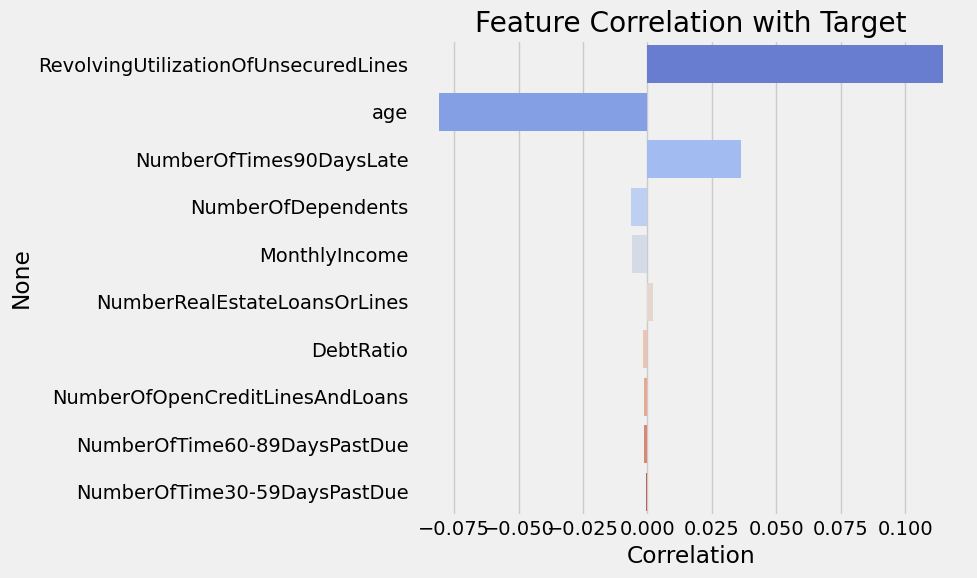

In [3]:
# Statistical summary
print('Statistical Summary:')
display(df.describe().round(2))

# Correlation with target
plt.figure(figsize=(10, 6))
target_corr = df.corr()[target_col].drop(target_col).sort_values(key=abs, ascending=False)
sns.barplot(x=target_corr.values, y=target_corr.index, palette='coolwarm')
plt.title('Feature Correlation with Target')
plt.xlabel('Correlation')
plt.tight_layout()
plt.show()

---
## Section 3: Feature Engineering

Inspired by Kaggle winning approach:
- Age groups for better income imputation
- IQR outlier handling
- Delinquency categorization
- Log transform for skewed features

In [4]:
def preprocess(df):
    """Advanced preprocessing inspired by Kaggle winning solution."""
    df = df.copy()
    
    # 1. Create Age Groups
    bins = [0, 25, 35, 45, 55, 70, float('inf')]
    labels = [0, 1, 2, 3, 4, 5]
    df['age_group'] = pd.cut(df['age'], bins=bins, labels=labels, include_lowest=True)
    
    # 2. Impute MonthlyIncome by age group median
    median_income_by_age = df.groupby('age_group')['MonthlyIncome'].median()
    df['MonthlyIncome'] = df['MonthlyIncome'].replace(0, np.nan)
    df['MonthlyIncome'] = df.apply(
        lambda row: median_income_by_age[row['age_group']] if pd.isnull(row['MonthlyIncome']) else row['MonthlyIncome'],
        axis=1
    )
    
    # 3. Handle outliers with IQR
    outlier_cols = ['RevolvingUtilizationOfUnsecuredLines', 'DebtRatio', 'MonthlyIncome', 'NumberRealEstateLoansOrLines']
    for col in outlier_cols:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower = Q1 - 1.5 * IQR
        upper = Q3 + 1.5 * IQR
        df[col] = df[col].clip(lower=lower, upper=upper)
    
    # 4. Convert delinquency counts to categories (0=none, 1=mild, 2=severe)
    df['Due_30_59'] = df['NumberOfTime30-59DaysPastDue'].apply(lambda x: 0 if x == 0 else 1 if x < 5 else 2)
    df['Due_60_89'] = df['NumberOfTime60-89DaysPastDue'].apply(lambda x: 0 if x == 0 else 1 if x < 5 else 2)
    df['Due_90_plus'] = df['NumberOfTimes90DaysLate'].apply(lambda x: 0 if x == 0 else 1 if x < 5 else 2)
    
    # 5. NumberOfDependents: binary + fill missing
    df['NumberOfDependents'] = df['NumberOfDependents'].apply(lambda x: 0 if x == 0 else 1)
    df['NumberOfDependents'] = df['NumberOfDependents'].fillna(df['NumberOfDependents'].mode()[0])
    
    # 6. Log transform skewed feature
    df['NumberOfOpenCreditLinesAndLoans'] = np.log1p(df['NumberOfOpenCreditLinesAndLoans'])
    
    # 7. Drop original columns replaced by engineered ones
    drop_cols = ['NumberOfTime30-59DaysPastDue', 'NumberOfTime60-89DaysPastDue', 
                 'NumberOfTimes90DaysLate', 'age']
    df = df.drop(drop_cols, axis=1)
    
    return df

df_processed = preprocess(df)
print(f'Features after preprocessing: {df_processed.shape[1]}')
print(f'Missing values remaining: {df_processed.isnull().sum().sum()}')
df_processed.head()

KeyError: 'NumberOfTime30-59DaysPastDueNotWorse'

---
## Section 4: Train/Test Split & Column Transformer

In [ ]:
# Define feature types
cat_cols = ['NumberRealEstateLoansOrLines', 'NumberOfDependents', 'age_group', 'Due_30_59', 'Due_60_89', 'Due_90_plus']
num_cols = ['RevolvingUtilizationOfUnsecuredLines', 'DebtRatio', 'MonthlyIncome', 'NumberOfOpenCreditLinesAndLoans']

# Prepare X and y
X = df_processed.drop(target_col, axis=1)
y = df_processed[target_col]

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Class imbalance weight
scale_pos_weight = (y_train == 0).sum() / (y_train == 1).sum()

# Column transformer
col_transformer = make_column_transformer(
    (OneHotEncoder(handle_unknown='ignore', sparse_output=False), cat_cols),
    (StandardScaler(), num_cols),
    remainder='passthrough'
)

print(f'Training set: {len(X_train):,} samples')
print(f'Test set: {len(X_test):,} samples')
print(f'Class imbalance ratio: {scale_pos_weight:.2f}')

---
## Section 5: Model Training & Comparison

In [ ]:
# 1. Logistic Regression (Balanced)
print('='*60)
print('MODEL 1: LOGISTIC REGRESSION')
print('='*60)

logit_pipeline = Pipeline([
    ('preprocess', col_transformer),
    ('clf', LogisticRegression(class_weight='balanced', random_state=42, max_iter=1000))
])
logit_pipeline.fit(X_train, y_train)

y_pred_logit = logit_pipeline.predict(X_test)
y_prob_logit = logit_pipeline.predict_proba(X_test)[:, 1]

print(f'Precision: {precision_score(y_test, y_pred_logit):.4f}')
print(f'Recall:    {recall_score(y_test, y_pred_logit):.4f}')
print(f'F1:        {f1_score(y_test, y_pred_logit):.4f}')
print(f'ROC-AUC:   {roc_auc_score(y_test, y_prob_logit):.4f}')

In [ ]:
# 2. Random Forest (Balanced)
print('='*60)
print('MODEL 2: RANDOM FOREST')
print('='*60)

rf_pipeline = Pipeline([
    ('preprocess', col_transformer),
    ('clf', RandomForestClassifier(
        class_weight='balanced', n_estimators=200, max_depth=6, 
        min_samples_leaf=2, random_state=42, n_jobs=-1
    ))
])
rf_pipeline.fit(X_train, y_train)

y_pred_rf = rf_pipeline.predict(X_test)
y_prob_rf = rf_pipeline.predict_proba(X_test)[:, 1]

print(f'Precision: {precision_score(y_test, y_pred_rf):.4f}')
print(f'Recall:    {recall_score(y_test, y_pred_rf):.4f}')
print(f'F1:        {f1_score(y_test, y_pred_rf):.4f}')
print(f'ROC-AUC:   {roc_auc_score(y_test, y_prob_rf):.4f}')

In [ ]:
# 3. XGBoost
print('='*60)
print('MODEL 3: XGBOOST')
print('='*60)

xgb_pipeline = Pipeline([
    ('preprocess', col_transformer),
    ('clf', XGBClassifier(
        objective='binary:logistic', eval_metric='logloss',
        scale_pos_weight=scale_pos_weight, n_estimators=200, max_depth=4,
        learning_rate=0.1, random_state=42, n_jobs=-1
    ))
])
xgb_pipeline.fit(X_train, y_train)

y_pred_xgb = xgb_pipeline.predict(X_test)
y_prob_xgb = xgb_pipeline.predict_proba(X_test)[:, 1]

print(f'Precision: {precision_score(y_test, y_pred_xgb):.4f}')
print(f'Recall:    {recall_score(y_test, y_pred_xgb):.4f}')
print(f'F1:        {f1_score(y_test, y_pred_xgb):.4f}')
print(f'ROC-AUC:   {roc_auc_score(y_test, y_prob_xgb):.4f}')

In [ ]:
# 4. LightGBM
print('='*60)
print('MODEL 4: LIGHTGBM')
print('='*60)

lgbm_pipeline = Pipeline([
    ('preprocess', col_transformer),
    ('clf', lgb.LGBMClassifier(
        objective='binary', metric='auc',
        scale_pos_weight=scale_pos_weight, n_estimators=300, max_depth=6,
        num_leaves=31, learning_rate=0.05, random_state=42, verbose=-1, n_jobs=-1
    ))
])
lgbm_pipeline.fit(X_train, y_train)

y_pred_lgbm = lgbm_pipeline.predict(X_test)
y_prob_lgbm = lgbm_pipeline.predict_proba(X_test)[:, 1]

print(f'Precision: {precision_score(y_test, y_pred_lgbm):.4f}')
print(f'Recall:    {recall_score(y_test, y_pred_lgbm):.4f}')
print(f'F1:        {f1_score(y_test, y_pred_lgbm):.4f}')
print(f'ROC-AUC:   {roc_auc_score(y_test, y_prob_lgbm):.4f}')

In [ ]:
# Model Comparison Table
print('='*70)
print('MODEL COMPARISON')
print('='*70)

comparison = pd.DataFrame({
    'Model': ['Logistic Regression', 'Random Forest', 'XGBoost', 'LightGBM'],
    'Precision': [
        precision_score(y_test, y_pred_logit),
        precision_score(y_test, y_pred_rf),
        precision_score(y_test, y_pred_xgb),
        precision_score(y_test, y_pred_lgbm)
    ],
    'Recall': [
        recall_score(y_test, y_pred_logit),
        recall_score(y_test, y_pred_rf),
        recall_score(y_test, y_pred_xgb),
        recall_score(y_test, y_pred_lgbm)
    ],
    'F1': [
        f1_score(y_test, y_pred_logit),
        f1_score(y_test, y_pred_rf),
        f1_score(y_test, y_pred_xgb),
        f1_score(y_test, y_pred_lgbm)
    ],
    'ROC-AUC': [
        roc_auc_score(y_test, y_prob_logit),
        roc_auc_score(y_test, y_prob_rf),
        roc_auc_score(y_test, y_prob_xgb),
        roc_auc_score(y_test, y_prob_lgbm)
    ]
}).round(4)

display(comparison)

best_idx = comparison['ROC-AUC'].idxmax()
print(f"\nBest Model: {comparison.loc[best_idx, 'Model']} (ROC-AUC: {comparison.loc[best_idx, 'ROC-AUC']:.4f})")

---
## Section 6: Threshold Tuning (Best Model)

In [ ]:
# Use best model probabilities
y_prob_best = y_prob_lgbm

print('='*70)
print('THRESHOLD ANALYSIS')
print('='*70)

thresholds = [0.3, 0.4, 0.5, 0.6, 0.7]
threshold_results = []

for thresh in thresholds:
    y_pred_t = (y_prob_best >= thresh).astype(int)
    threshold_results.append({
        'Threshold': thresh,
        'Precision': precision_score(y_test, y_pred_t),
        'Recall': recall_score(y_test, y_pred_t),
        'F1': f1_score(y_test, y_pred_t)
    })

thresh_df = pd.DataFrame(threshold_results).round(4)
display(thresh_df)

print('\nUse Cases:')
print('  - Threshold 0.3: Flag risky profiles (high recall)')
print('  - Threshold 0.5: Balanced system')
print('  - Threshold 0.7: Auto-reject high-risk only (high precision)')

---
## Section 7: Final Model Evaluation

In [ ]:
# Final evaluation with best model
best_model = lgbm_pipeline
y_pred_final = y_pred_lgbm
y_prob_final = y_prob_lgbm

print('='*60)
print('FINAL MODEL: LIGHTGBM')
print('='*60)

roc_auc = roc_auc_score(y_test, y_prob_final)
pr_auc = average_precision_score(y_test, y_prob_final)

print(f'\nROC-AUC: {roc_auc:.4f}')
print(f'PR-AUC:  {pr_auc:.4f}')
print(f'Gini:    {2*roc_auc - 1:.4f}')

print('\nClassification Report:')
print(classification_report(y_test, y_pred_final, target_names=['No Default', 'Default']))

print('Confusion Matrix:')
print(confusion_matrix(y_test, y_pred_final))

In [ ]:
# ROC and PR Curves
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# ROC Curve for all models
for name, probs in [('Logistic', y_prob_logit), ('RF', y_prob_rf), ('XGB', y_prob_xgb), ('LGBM', y_prob_lgbm)]:
    fpr, tpr, _ = roc_curve(y_test, probs)
    auc = roc_auc_score(y_test, probs)
    axes[0].plot(fpr, tpr, lw=2, label=f'{name} (AUC={auc:.3f})')

axes[0].plot([0, 1], [0, 1], 'k--')
axes[0].set_xlabel('False Positive Rate')
axes[0].set_ylabel('True Positive Rate')
axes[0].set_title('ROC Curves')
axes[0].legend(loc='lower right')

# PR Curve
for name, probs in [('Logistic', y_prob_logit), ('RF', y_prob_rf), ('XGB', y_prob_xgb), ('LGBM', y_prob_lgbm)]:
    precision, recall, _ = precision_recall_curve(y_test, probs)
    pr_auc_val = average_precision_score(y_test, probs)
    axes[1].plot(recall, precision, lw=2, label=f'{name} (AP={pr_auc_val:.3f})')

axes[1].set_xlabel('Recall')
axes[1].set_ylabel('Precision')
axes[1].set_title('Precision-Recall Curves')
axes[1].legend(loc='upper right')

plt.tight_layout()
plt.show()

---
## Section 8: Save Model

In [ ]:
# Save best model pipeline
model_path = os.path.join(MODEL_DIR, 'credit_risk_pipeline.pkl')
joblib.dump(best_model, model_path)
print(f'Model saved to: {model_path}')

---
## Summary

In [ ]:
print('='*60)
print('FINAL SUMMARY')
print('='*60)
print(f'\nDataset: {len(df):,} samples')
print(f'Default rate: {df[target_col].mean()*100:.2f}%')
print(f'\nBest Model: LightGBM')
print(f'  ROC-AUC: {roc_auc:.4f}')
print(f'  PR-AUC:  {pr_auc:.4f}')
print(f'  Gini:    {2*roc_auc - 1:.4f}')
print(f'\nModel saved to: {model_path}')